In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import pandas
import numpy
import joblib

pandas.plotting.register_matplotlib_converters()

Using TensorFlow backend.


In [2]:
def graphicplotxy(x, y, x_label, y_label, title, filename):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(x, y, alpha=0.70, )
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(['MSE'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    
    plt.show
    plt.savefig(filename)

def to_supervised(data, n_in, n_out):
    n_vars = 1
    df = pandas.DataFrame(data)
    cols, names = list(), list()
    # urutan waktu input ke t- (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # urutan waktu output ke t+ (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]          
    # concat
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop baris yang bernilai Nan
    agg.dropna(inplace=True)
    val = agg.values
    X, y = val[:, 0:n_in], val[:, n_in:]
    #reshape(sample, timestep, feature/input)
    X = X.reshape((X.shape[0], 1, n_in))
    return X, y

def eksperimen(nama, model, scaler, set_latih, set_uji, n_input = 1, n_neuron = 30, n_epoch = 40):
    n_timestep = 1
    n_output = 1

    print("Hyperparameter {0}".format(nama))
    print("input = {0}\nneuron = {1}\nepoch = {2}".format(n_input, n_neuron, n_epoch))
    
    # sliding windows
    X_train, y_train = to_supervised(set_latih, n_input, n_output)
    
    # Compile Model input_shape=(n_timesteps, n_features/input)
    model.add(LSTM(n_neuron, input_shape=(n_timestep, n_input)))
    model.add(Dense(n_output))
    model.compile(loss='mse', optimizer='adam')

    print("\nPelatihan {0} Mulai".format(nama))
    model.fit(X_train, y_train, epochs=n_epoch, verbose=0)
    model.save("{0}.h5".format(nama))
    print("Pelatihan {0} Selesai".format(nama))

    print("\nPengujian {0}".format(nama))
    X_test, y_test = to_supervised(set_uji, n_input, n_output)
    mse = model.evaluate(X_test, y_test)
    print("{0} MSE = {1}".format(nama, mse))

    print("\n-------------------------------------------------------------------------------------------\n")

In [3]:
#load data
set_latih = numpy.loadtxt('set_latih.csv', delimiter=",")
set_uji = numpy.loadtxt('set_uji.csv', delimiter=",")
scaler = joblib.load('scaler.gz')

In [4]:
# MS1
MS1 = Sequential()
eksperimen("MS1", MS1, scaler, set_latih, set_uji, n_input = 1, n_neuron = 30, n_epoch = 40)

# MS2
MS2 = Sequential()
eksperimen("MS2", MS2, scaler, set_latih, set_uji, n_input = 2, n_neuron = 30, n_epoch = 40)

# MS3
MS3 = Sequential()
eksperimen("MS3", MS3, scaler, set_latih, set_uji, n_input = 4, n_neuron = 30, n_epoch = 40)

# MS4
MS4 = Sequential()
eksperimen("MS4", MS4, scaler, set_latih, set_uji, n_input = 8, n_neuron = 30, n_epoch = 40)

# MS5
MS5 = Sequential()
eksperimen("MS5", MS5, scaler, set_latih, set_uji, n_input = 16, n_neuron = 30, n_epoch = 40)

# MS6
MS6 = Sequential()
eksperimen("MS6", MS6, scaler, set_latih, set_uji, n_input = 32, n_neuron = 30, n_epoch = 40)

# MS7
MS7 = Sequential()
eksperimen("MS7", MS7, scaler, set_latih, set_uji, n_input = 64, n_neuron = 30, n_epoch = 40)

# MS8
MS8 = Sequential()
eksperimen("MS8", MS8, scaler, set_latih, set_uji, n_input = 128, n_neuron = 30, n_epoch = 40)

# MS9
MS9 = Sequential()
eksperimen("MS9", MS9, scaler, set_latih, set_uji, n_input = 256, n_neuron = 30, n_epoch = 40)

# MS10
MS10 = Sequential()
eksperimen("MS10", MS10, scaler, set_latih, set_uji, n_input = 512, n_neuron = 30, n_epoch = 40)

Hyperparameter MS1
input = 1
neuron = 30
epoch = 40

Pelatihan MS1 Mulai
Pelatihan MS1 Selesai

Pengujian MS1
1088/1088 [==============================] - 0s 70us/step
MS1 MSE = 0.0652440864702358

-------------------------------------------------------------------------------------------

Hyperparameter MS2
input = 2
neuron = 30
epoch = 40

Pelatihan MS2 Mulai
Pelatihan MS2 Selesai

Pengujian MS2
1087/1087 [==============================] - 0s 75us/step
MS2 MSE = 0.06348026661063513

-------------------------------------------------------------------------------------------

Hyperparameter MS3
input = 4
neuron = 30
epoch = 40

Pelatihan MS3 Mulai
Pelatihan MS3 Selesai

Pengujian MS3
1085/1085 [==============================] - 0s 73us/step
MS3 MSE = 0.06330219533998296

-------------------------------------------------------------------------------------------

Hyperparameter MS4
input = 8
neuron = 30
epoch = 40

Pelatihan MS4 Mulai
Pelatihan MS4 Selesai

Pengujian MS4
1081/1081 [====

[0.065244,
 0.06348,
 0.063302,
 0.062606,
 0.062289,
 0.064702,
 0.069326,
 0.07768,
 0.090824,
 0.076223]

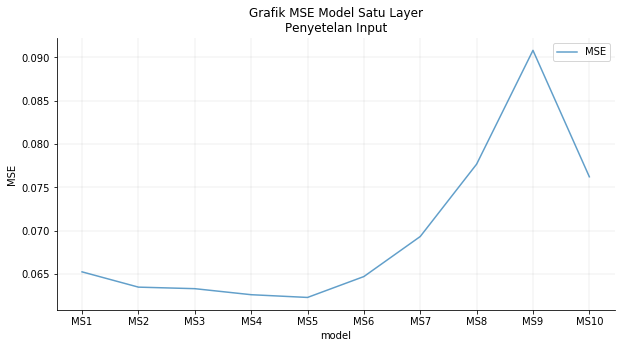

In [5]:
mses = [round(0.0652440864702358, 6),
        round(0.06348026661063513, 6),
        round(0.06330219533998296, 6),
        round(0.06260601675808154, 6),
        round(0.062288638152258484, 6), # BEST MS5
        round(0.06470182757602622, 6), 
        round(0.06932558613942891, 6),
        round(0.07768029665659713, 6), 
        round(0.0908238300152228, 6),
        round(0.07622253435116706, 6),
       ]
labels = ["MS1","MS2","MS3","MS4","MS5","MS6", "MS7", "MS8", "MS9", "MS10"]
graphicplotxy(labels, mses, "model", "MSE", "Grafik MSE Model Satu Layer\nPenyetelan Input", "MS_Train_Input.png")
mses

In [6]:
# MS11
MS11 = Sequential()
eksperimen("MS11", MS11, scaler, set_latih, set_uji, n_input = 16, n_neuron = 1, n_epoch = 40)

# MS12
MS12 = Sequential()
eksperimen("MS12", MS12, scaler, set_latih, set_uji, n_input = 16, n_neuron = 2, n_epoch = 40)

# MS13
MS13 = Sequential()
eksperimen("MS13", MS13, scaler, set_latih, set_uji, n_input = 16, n_neuron = 4, n_epoch = 40)

# MS14
MS14 = Sequential()
eksperimen("MS14", MS14, scaler, set_latih, set_uji, n_input = 16, n_neuron = 8, n_epoch = 40)

# MS15
MS15 = Sequential()
eksperimen("MS15", MS15, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 40)

# MS16
MS16 = Sequential()
eksperimen("MS16", MS16, scaler, set_latih, set_uji, n_input = 16, n_neuron = 32, n_epoch = 40)

# MS17
MS17 = Sequential()
eksperimen("MS17", MS17, scaler, set_latih, set_uji, n_input = 16, n_neuron = 64, n_epoch = 40)

# MS18
MS18 = Sequential()
eksperimen("MS18", MS18, scaler, set_latih, set_uji, n_input = 16, n_neuron = 128, n_epoch = 40)

# MS19
MS19 = Sequential()
eksperimen("MS19", MS19, scaler, set_latih, set_uji, n_input = 16, n_neuron = 256, n_epoch = 40)

# MS20
MS20 = Sequential()
eksperimen("MS20", MS20, scaler, set_latih, set_uji, n_input = 16, n_neuron = 512, n_epoch = 40)

Hyperparameter MS11
input = 16
neuron = 1
epoch = 40

Pelatihan MS11 Mulai
Pelatihan MS11 Selesai

Pengujian MS11
1073/1073 [==============================] - 0s 62us/step
MS11 MSE = 0.06307472933677458

-------------------------------------------------------------------------------------------

Hyperparameter MS12
input = 16
neuron = 2
epoch = 40

Pelatihan MS12 Mulai
Pelatihan MS12 Selesai

Pengujian MS12
1073/1073 [==============================] - 0s 66us/step
MS12 MSE = 0.06287879920030795

-------------------------------------------------------------------------------------------

Hyperparameter MS13
input = 16
neuron = 4
epoch = 40

Pelatihan MS13 Mulai
Pelatihan MS13 Selesai

Pengujian MS13
1073/1073 [==============================] - 0s 67us/step
MS13 MSE = 0.06219958521266019

-------------------------------------------------------------------------------------------

Hyperparameter MS14
input = 16
neuron = 8
epoch = 40

Pelatihan MS14 Mulai
Pelatihan MS14 Selesai

Pengujian 

[0.063075,
 0.062879,
 0.0622,
 0.061948,
 0.061923,
 0.062289,
 0.061959,
 0.062536,
 0.063814,
 0.063064,
 0.062739]

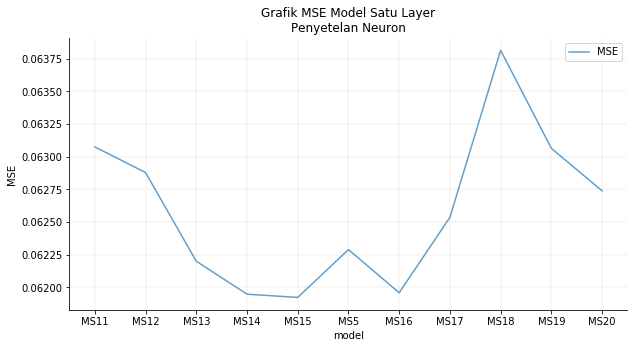

In [8]:
mses = [round(0.06307472933677458, 6),
        round(0.06287879920030795, 6),
        round(0.06219958521266019, 6),
        round(0.06194787357915592, 6),
        round(0.061923258891893346, 6), #BEST MS15
        round(0.062288638152258484, 6), #MS5
        round(0.0619590068782809, 6), 
        round(0.06253556040604316, 6), 
        round(0.06381439696737015, 6),
        round(0.06306423957547293, 6),
        round(0.06273888054287334, 6),
       ]
labels = ["MS11","MS12","MS13","MS14","MS15","MS5","MS16", "MS17", "MS18", "MS19", "MS20"]
graphicplotxy(labels, mses, "model", "MSE", "Grafik MSE Model Satu Layer\nPenyetelan Neuron", "MS_Train_Neuron.png")
mses

In [9]:
# MS21
MS21 = Sequential()
eksperimen("MS21", MS21, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 2)

# MS22
MS22 = Sequential()
eksperimen("MS22", MS22, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 4)

# MS23
MS23 = Sequential()
eksperimen("MS23", MS23, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 8)

# MS24
MS24 = Sequential()
eksperimen("MS24", MS24, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 16)

# MS25
MS25 = Sequential()
eksperimen("MS25", MS25, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 32)

# MS26
MS26 = Sequential()
eksperimen("MS26", MS26, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 64)

# MS27
MS27 = Sequential()
eksperimen("MS27", MS27, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 128)

# MS28
MS28 = Sequential()
eksperimen("MS28", MS28, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 256)

# MS29
MS29 = Sequential()
eksperimen("MS29", MS29, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 512)

# MS30
MS30 = Sequential()
eksperimen("MS30", MS30, scaler, set_latih, set_uji, n_input = 16, n_neuron = 16, n_epoch = 1024)

Hyperparameter MS21
input = 16
neuron = 16
epoch = 2

Pelatihan MS21 Mulai
Pelatihan MS21 Selesai

Pengujian MS21
1073/1073 [==============================] - 0s 74us/step
MS21 MSE = 0.0668087152474302

-------------------------------------------------------------------------------------------

Hyperparameter MS22
input = 16
neuron = 16
epoch = 4

Pelatihan MS22 Mulai
Pelatihan MS22 Selesai

Pengujian MS22
1073/1073 [==============================] - 0s 76us/step
MS22 MSE = 0.06467423470341926

-------------------------------------------------------------------------------------------

Hyperparameter MS23
input = 16
neuron = 16
epoch = 8

Pelatihan MS23 Mulai
Pelatihan MS23 Selesai

Pengujian MS23
1073/1073 [==============================] - 0s 79us/step
MS23 MSE = 0.06407330952452814

-------------------------------------------------------------------------------------------

Hyperparameter MS24
input = 16
neuron = 16
epoch = 16

Pelatihan MS24 Mulai
Pelatihan MS24 Selesai

Pengujian 

[0.066809,
 0.064674,
 0.064073,
 0.062273,
 0.062319,
 0.061923,
 0.063112,
 0.066153,
 0.070979,
 0.077181,
 0.103342]

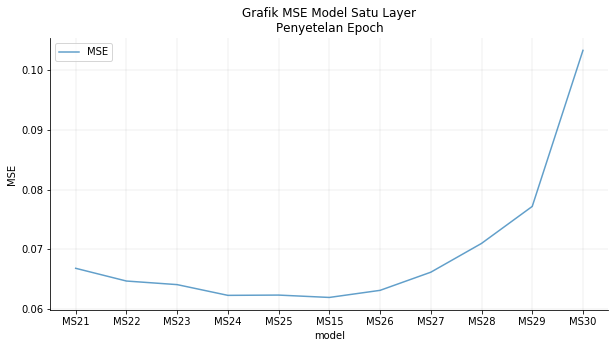

In [12]:
mses = [round(0.0668087152474302, 6),
        round(0.06467423470341926, 6),
        round(0.06407330952452814, 6),
        round(0.062273266674032414, 6),
        round(0.0623187506146111, 6),
        round(0.061923258891893346, 6), #MS15 BEST
        round(0.0631119376334873, 6), 
        round(0.06615345915718714, 6),
        round(0.07097909919993964, 6), 
        round(0.07718145565406696, 6), 
        round(0.10334206795370257, 6),
       ]
labels = ["MS21","MS22","MS23","MS24","MS25","MS15", "MS26", "MS27", "MS28", "MS29", "MS30"]
graphicplotxy(labels, mses, "model", "MSE", "Grafik MSE Model Satu Layer\nPenyetelan Epoch", "MS_Train_Epoch.png")
mses

0.44126074498567314